# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import heapq
import re
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [2]:
df = pd.read_csv("train/train.csv")
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


## Feature Analysis

In [3]:
df['text_length'] = df["text"].apply(lambda x: len(x.split()))
author_names = df['author'].unique()
authors_df_list = []
word_summary = []
for author in author_names:
    author_df = df[df['author'] == author].rename(columns={'text_length' : f"{author}_text_length"})
    top_ten_word_counts = heapq.nlargest(10, author_df[f"{author}_text_length"])
    print(f"The highest 10 word counts from {author} were {top_ten_word_counts}.")
    authors_df_list.append(author_df)
    word_summary.append(author_df[f"{author}_text_length"].describe())
word_summary_df = pd.concat(word_summary, axis=1)
word_summary_df

The highest 10 word counts from EAP were [267, 256, 169, 164, 157, 149, 148, 148, 140, 137].
The highest 10 word counts from HPL were [147, 134, 117, 113, 113, 108, 102, 102, 100, 99].
The highest 10 word counts from MWS were [861, 594, 445, 377, 335, 191, 190, 186, 186, 181].


,EAP_text_length,HPL_text_length,MWS_text_length
count,7900.000000,5635.000000,6044.000000
mean,25.442405,27.799645,27.417273
std,18.567706,14.123252,23.134440
min,2.000000,4.000000,2.000000
25%,12.000000,18.000000,15.000000
50%,21.000000,26.000000,23.000000
75%,33.000000,35.000000,34.000000
max,267.000000,147.000000,861.000000


In [4]:
max_word_count = 200
for i, author in enumerate(author_names):
    initial_count = len(authors_df_list[i])
    authors_df_list[i] = authors_df_list[i][authors_df_list[i][f'{author}_text_length'] <= max_word_count]
    print(f"{author} had {initial_count - len(authors_df_list[i])} texts with more than {max_word_count} words. ")
df = df[df['text_length'] <= max_word_count]

EAP had 2 texts with more than 200 words. 
HPL had 0 texts with more than 200 words. 
MWS had 5 texts with more than 200 words. 


It is important to note that most of these samples fall within the range of 200. This means that we should remove the 9 entries (2 from EAP and 7 from MWS) that have more than 200 entries and consider them outliers. While a more strict boundary may be chosen, one must remember the importance of not "overfitting by hand". Choosing a loose boundary that only gets rid of large outlier helps improve generalizability. 

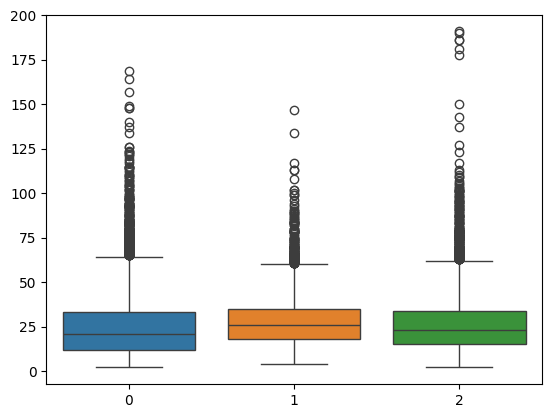

In [5]:
#TODO: rename below variable
word_list = []
for i, author in enumerate(author_names):
    word_list.append(authors_df_list[i][f"{author}_text_length"].values)
_ = sns.boxplot(data=word_list)

## Preprocessing

In [6]:
from sklearn.preprocessing import OneHotEncoder
def bag_of_words(df) :
    labels = df["author"]
    df = df.drop(columns=["id", "author"])

    # Remove punctuation
    to_remove = ['.', ',', '?', '!', ':', ';']
    replacement = " "

    pattern = "|".join(map(re.escape, to_remove))
    df["text"] = df["text"].str.replace(pattern, replacement, regex=True)

    # Tokenization
    vectorizer = CountVectorizer(lowercase=True, binary=True) # Binary makes values 0/1
    X = vectorizer.fit_transform(df["text"])
    print(X.shape)

    return X, labels

csr_matrix, labels = bag_of_words(df)
labelEncoder = OneHotEncoder(sparse_output=False)
labels = labelEncoder.fit_transform(pd.DataFrame(labels))

(19572, 25023)


In [7]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu' 

# 70-20-10 split
train_val_test_split = [0.7, 0.2, 0.1]

X = torch.sparse_coo_tensor(csr_matrix.nonzero(), np.array(csr_matrix.data), csr_matrix.shape, dtype=torch.double)
y = torch.tensor(labels, device=device)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True, drop_last=True)
train_dataloader, val_dataloader, test_dataloader = random_split(dataset, train_val_test_split)

C:\Users\YUGAN\AppData\Local\Temp\ipykernel_32428\2191032978.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X = torch.sparse_coo_tensor(csr_matrix.nonzero(), np.array(csr_matrix.data), csr_matrix.shape, dtype=torch.double)


# Model Definition

In [9]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch 
from tqdm import tqdm
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(25023, 16, dtype=torch.double)
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(16, 3, dtype=torch.double)
        self.softmax = nn.Softmax(0)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x
    
    def mini_batch(self, train: bool, dataloader : DataLoader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss) -> float:
        running_loss = 0
        if(train):
            self.train(True)
            for X_batch, y_batch in dataloader:
                optimizer.zero_grad()
                outputs = self.forward(X_batch)
                loss = criterion(y_batch, outputs)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
        else:
            self.train(False)
            for X_batch, y_batch in dataloader:
                outputs = self.forward(X_batch)
                loss = criterion(y_batch, outputs)

                running_loss += loss.item()
        average_loss = running_loss/len(dataloader)
        return average_loss

# Create an instance of the network
model = LinearModel()
model = model.to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100
train_losses = []
val_losses = []
epochs = range(1, num_epochs+1)
for epoch in tqdm(epochs):
    train = True
    train_loss = model.mini_batch(train=train, dataloader=train_dataloader, optimizer=optimizer, criterion=criterion)
    train = False
    val_loss = model.mini_batch(train=train, dataloader=val_dataloader, optimizer=optimizer, criterion=criterion)
    print(f"The training loss was: {train_loss} and the validation loss was: {val_loss}.")
    train_losses.append(train_loss)
    val_losses.append(val_loss)

  0%|          | 0/100 [01:29<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
_ = plt.plot(epochs, train_loss, color='b', label="Train Loss")
_ = plt.plot(epochs, val_loss, color='r', label="Val Loss")
_ = plt.legend()
plt.show()